In [2]:
import os

dataDir = "coe379l-fa25/datasets/unit03/Project2/"
damagedDir = os.path.join(dataDir, "damage")
noDamagedDir = os.path.join(dataDir, "no_damage")

In [3]:
damagedImagePaths = [os.path.join(damagedDir, f) for f in os.listdir(damagedDir) if f.endswith(('.png', '.jpg', '.jpeg'))]
noDamageImagePaths = [os.path.join(noDamagedDir, f) for f in os.listdir(noDamagedDir) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

damagedImages = []
noDamageImages = []

# we will use tensorflow to read in the image files because we ultimately are going to use tensorflow to build our models
# [1]
for path in damagedImagePaths:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    damagedImages.append(img)

for path in noDamageImagePaths:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    noDamageImages.append(img)

damaged images


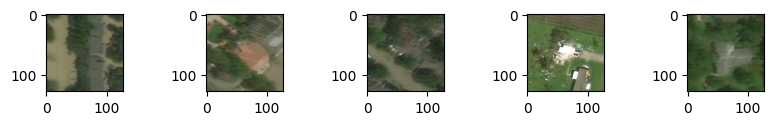

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))
for i in range(5):
    # Set the (i+1)st subplot in a plot with 5 images in 1 row.
    plt.subplot(1, 5, i+1)
    plt.imshow(damagedImages[i])
print("damaged images")

undamaged images


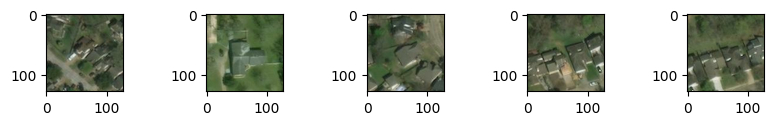

In [6]:
plt.figure(figsize=(10, 1))
for i in range(5):
    # Set the (i+1)st subplot in a plot with 5 images in 1 row.
    plt.subplot(1, 5, i+1)
    plt.imshow(noDamageImages[i])
print("undamaged images")

In [7]:
damagedImages[0].shape

TensorShape([128, 128, 3])

In [8]:
print(len(damagedImages))
print(len(noDamageImages))

14170
7152


In [9]:
# we have images which are 128x128 with 3 channels (RGB) - we must remember this when it comes to the input dimension to our neural networks
# we also see that we have 14170 images of damaged houses and 7152 images of non-damaged houses

In [10]:
# now lets combine all of the images into one labelled dataset
# [2]

# turn the python lists into tf dataset objects
tfdamagedImages = tf.data.Dataset.from_tensor_slices(damagedImages)
tfnoDamageImages = tf.data.Dataset.from_tensor_slices(noDamageImages)

# add labels
tfdamagedImages = tfdamagedImages.map(lambda x: (x, 1))
tfnoDamageImages = tfnoDamageImages.map(lambda x: (x, 0))

# combine into one dataset
data = tfdamagedImages.concatenate(tfnoDamageImages)

# [3]
def normalizeImage(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # convert to float & scale
    return image, label

data = data.map(normalizeImage, num_parallel_calls=tf.data.AUTOTUNE)

def build_dataset(dataset, batch_size):
    return(
        dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

In [11]:
# now we want to split the data into test and train sets, I will hold off on creating a validation set and just use the built in methods for this
# here I won't do any rescaling because I mostly want to build my own neural nets... perhaps if I decide to use VGGNet16 then I will resize just for that
# I also won't convert images to grayscale immediately - my intuition says that the color of these datasets is important because a destroyed house
# will have more exposed wood, and will therefore be more brown - but maybe I can play with this later and see how well models perform on grayscale

# now lets create test and train sets
# I won't create a strict validation set and will instead just holdout a validation set during training using the built in methods
dataSize = 14170 + 7152
trainSize = int(0.75*dataSize)
testSize = int(0.15*dataSize)
valSize = int(0.1*dataSize)

data = data.shuffle(buffer_size=dataSize, seed=6, reshuffle_each_iteration=False)

trainSet = data.take(trainSize)
remaining = data.skip(trainSize)

testSet = remaining.take(testSize)
valSet = remaining.skip(testSize)

# now we want to batch our datasets
trainSet = trainSet.shuffle(buffer_size=dataSize, seed=6, reshuffle_each_iteration=True)
trainSet = build_dataset(trainSet, 32)
testSet = build_dataset(testSet, 32)
valSet = build_dataset(valSet, 32)

In [11]:
# print(X_train.shape, X_test.shape)

In [12]:
#### PART 2 ####
# Now we will start to try to build some neural nets
# First lets construct the simple ANN that we built in class

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input

inputDimension = 128*128*3

ANN1 = Sequential()

# first flatten the data
ANN1.add(Input(shape=(128, 128, 3)))
ANN1.add(Flatten())

ANN1.add(Dense(256, activation='relu'))
ANN1.add(Dense(128, activation='relu'))
ANN1.add(Dense(1, activation='sigmoid'))

ANN1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
ANN1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12616193 (48.13 MB)
Trainable params: 12616193 (48.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
ANN1.fit(trainSet, validation_data=valSet, epochs=20, verbose=2)

Epoch 1/20
500/500 - 47s - loss: 0.8644 - accuracy: 0.6359 - val_loss: 0.6297 - val_accuracy: 0.6296 - 47s/epoch - 94ms/step
Epoch 2/20
500/500 - 45s - loss: 0.5869 - accuracy: 0.7012 - val_loss: 0.5549 - val_accuracy: 0.7234 - 45s/epoch - 89ms/step
Epoch 3/20
500/500 - 43s - loss: 0.5621 - accuracy: 0.7248 - val_loss: 0.5324 - val_accuracy: 0.7586 - 43s/epoch - 86ms/step
Epoch 4/20
500/500 - 45s - loss: 0.5943 - accuracy: 0.6956 - val_loss: 0.6283 - val_accuracy: 0.6770 - 45s/epoch - 89ms/step
Epoch 5/20
500/500 - 43s - loss: 0.6182 - accuracy: 0.6627 - val_loss: 0.6144 - val_accuracy: 0.6770 - 43s/epoch - 85ms/step
Epoch 6/20
500/500 - 43s - loss: 0.6076 - accuracy: 0.6626 - val_loss: 0.6030 - val_accuracy: 0.6770 - 43s/epoch - 87ms/step
Epoch 7/20
500/500 - 46s - loss: 0.5872 - accuracy: 0.6731 - val_loss: 0.5872 - val_accuracy: 0.7281 - 46s/epoch - 91ms/step
Epoch 8/20
500/500 - 44s - loss: 0.5777 - accuracy: 0.7145 - val_loss: 0.5566 - val_accuracy: 0.7300 - 44s/epoch - 89ms/step


In [14]:
# Its weird that my accuracy and val_accuracy has completely stabilized. Maybe my batch size is too small or my learing rate is too slow and it is 
# getting caught on a local minimum
# Maybe I will try to play with this later on

In [15]:
probs = ANN1.predict(testSet)
print(probs)

100/100 [==============================] - 2s 6ms/step
[[0.703478  ]
 [0.6561393 ]
 [0.3382376 ]
 ...
 [0.53608996]
 [0.3382376 ]
 [0.3382376 ]]


In [16]:
# this is weird - that looks like the percentage of damaged images in the set

14170 / dataSize

0.6645718037707532

In [17]:
# so my model is just learning to pick the average class

In [18]:
# Convert predictions
y_pred = (probs > 0.5).astype(int)

# Extract true labels
y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.6954346466541589


In [19]:
# I am going to try this again and use auc as my metric

ANN2 = ANN1
ANN2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.AUC()])
ANN1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12616193 (48.13 MB)
Trainable params: 12616193 (48.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
ANN2.fit(trainSet, validation_data=valSet, epochs=10, verbose=2)

Epoch 1/10
500/500 - 44s - loss: 0.5702 - auc: 0.7170 - val_loss: 0.5643 - val_auc: 0.7453 - 44s/epoch - 88ms/step
Epoch 2/10
500/500 - 42s - loss: 0.5683 - auc: 0.7279 - val_loss: 0.6598 - val_auc: 0.6656 - 42s/epoch - 83ms/step
Epoch 3/10
500/500 - 41s - loss: 0.5707 - auc: 0.7174 - val_loss: 0.5417 - val_auc: 0.7508 - 41s/epoch - 82ms/step
Epoch 4/10
500/500 - 42s - loss: 0.5742 - auc: 0.7136 - val_loss: 0.5428 - val_auc: 0.7550 - 42s/epoch - 85ms/step
Epoch 5/10
500/500 - 41s - loss: 0.5646 - auc: 0.7225 - val_loss: 0.5367 - val_auc: 0.7588 - 41s/epoch - 83ms/step
Epoch 6/10
500/500 - 40s - loss: 0.5639 - auc: 0.7282 - val_loss: 0.6126 - val_auc: 0.6939 - 40s/epoch - 80ms/step
Epoch 7/10
500/500 - 41s - loss: 0.5679 - auc: 0.7187 - val_loss: 0.5345 - val_auc: 0.7589 - 41s/epoch - 82ms/step
Epoch 8/10
500/500 - 41s - loss: 0.5698 - auc: 0.7194 - val_loss: 0.5393 - val_auc: 0.7572 - 41s/epoch - 81ms/step
Epoch 9/10
500/500 - 40s - loss: 0.5660 - auc: 0.7241 - val_loss: 0.5729 - val_a

In [21]:
probs_ANN2 = ANN2.predict(testSet)

y_pred = (probs_ANN2 > 0.5).astype(int)

# Evaluate
from sklearn.metrics import roc_auc_score
print("Accuracy:", accuracy_score(y_true, y_pred))
print("ROC:", roc_auc_score(y_true, probs_ANN2))

100/100 [==============================] - 2s 6ms/step
Accuracy: 0.7448405253283302
ROC: 0.7485419155365047


In [23]:
# I want to play with the decision boundary
threshold_probs_ANN2 = ANN2.predict(valSet)

y_val_true = np.concatenate([y.numpy() for x, y in valSet], axis=0)

y_pred = (threshold_probs_ANN2 > 0.5).astype(int)
print("Accuracy@0.5:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_ANN2 > 0.4).astype(int)
print("Accuracy@0.4:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_ANN2 > 0.3).astype(int)
print("Accuracy@0.3:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_ANN2 > 0.2).astype(int)
print("Accuracy@0.2:", accuracy_score(y_val_true, y_pred))

67/67 [==============================] - 1s 5ms/step
Accuracy@0.5: 0.7524613220815752
Accuracy@0.4: 0.7524613220815752
Accuracy@0.3: 0.6769807782466011
Accuracy@0.2: 0.6769807782466011


In [28]:
# now I'm going to try to using the LENET-5 architecture

from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D

LENET5_1 = Sequential()

# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
LENET5_1.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))
LENET5_1.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
LENET5_1.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
LENET5_1.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_1.add(Flatten())

# Layer 3: Fully connected layer with 120 neurons
LENET5_1.add(Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
LENET5_1.add(Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 10 for MNIST)
LENET5_1.add(Dense(1, activation='sigmoid'))

LENET5_1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [29]:
LENET5_1.fit(trainSet, validation_data=valSet, epochs=20, verbose=2)

Epoch 1/20
500/500 - 50s - loss: 0.3880 - accuracy: 0.8388 - val_loss: 0.3471 - val_accuracy: 0.8528 - 50s/epoch - 101ms/step
Epoch 2/20
500/500 - 47s - loss: 0.2864 - accuracy: 0.8881 - val_loss: 0.2895 - val_accuracy: 0.8865 - 47s/epoch - 94ms/step
Epoch 3/20
500/500 - 48s - loss: 0.2200 - accuracy: 0.9148 - val_loss: 0.2879 - val_accuracy: 0.8786 - 48s/epoch - 97ms/step
Epoch 4/20
500/500 - 50s - loss: 0.1679 - accuracy: 0.9352 - val_loss: 0.1940 - val_accuracy: 0.9273 - 50s/epoch - 100ms/step
Epoch 5/20
500/500 - 51s - loss: 0.1255 - accuracy: 0.9519 - val_loss: 0.2859 - val_accuracy: 0.8940 - 51s/epoch - 103ms/step
Epoch 6/20
500/500 - 50s - loss: 0.1043 - accuracy: 0.9610 - val_loss: 0.2106 - val_accuracy: 0.9264 - 50s/epoch - 101ms/step
Epoch 7/20
500/500 - 50s - loss: 0.0726 - accuracy: 0.9727 - val_loss: 0.1987 - val_accuracy: 0.9269 - 50s/epoch - 100ms/step
Epoch 8/20
500/500 - 49s - loss: 0.0483 - accuracy: 0.9835 - val_loss: 0.2585 - val_accuracy: 0.9325 - 49s/epoch - 98ms/

In [30]:
probs_LENET5_1 = LENET5_1.predict(testSet)

y_pred = (probs_LENET5_1 > 0.5).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 3s 17ms/step
Accuracy: 0.9171357098186367


In [31]:
threshold_probs_LENET5_1 = LENET5_1.predict(valSet)

y_pred = (threshold_probs_LENET5_1 > 0.5).astype(int)
print("Accuracy@0.5:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_1 > 0.6).astype(int)
print("Accuracy@0.6:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_1 > 0.7).astype(int)
print("Accuracy@0.7:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_1 > 0.8).astype(int)
print("Accuracy@0.8:", accuracy_score(y_val_true, y_pred))

67/67 [==============================] - 2s 17ms/step
Accuracy@0.5: 0.919831223628692
Accuracy@0.6: 0.9203000468823254
Accuracy@0.7: 0.9193624003750586
Accuracy@0.8: 0.9151429910923582


In [35]:
# although we see a slight improvement at 0.6, it is so minimal that it could easily just be the result of a noisy data split, I will keep the decision
# boundary at 0.5

In [36]:
# now we'll impliment the version of LENET5 used in this paper: https://arxiv.org/pdf/1807.01688

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2.add(Flatten())

# Add a 50% dropout layer
LENET5_2.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2.add(Dense(1, activation='sigmoid'))

LENET5_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.94609, saving model to best_model.keras
500/500 - 103s - loss: 0.3498 - accuracy: 0.8413 - val_loss: 0.1557 - val_accuracy: 0.9461 - 103s/epoch - 205ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.94609 to 0.95781, saving model to best_model.keras
500/500 - 108s - loss: 0.1532 - accuracy: 0.9395 - val_loss: 0.1227 - val_accuracy: 0.9578 - 108s/epoch - 216ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.95781 to 0.96156, saving model to best_model.keras
500/500 - 116s - loss: 0.1210 - accuracy: 0.9542 - val_loss: 0.0899 - val_accuracy: 0.9616 - 116s/epoch - 232ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.96156
500/500 - 101s - loss: 0.1043 - accuracy: 0.9600 - val_loss: 0.0963 - val_accuracy: 0.9616 - 101s/epoch - 202ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.96156 to 0.96437, saving model to best_model.keras
500/500 - 99s - loss: 0.0878 - accuracy: 0.9679 - val_loss: 0.0887 -

In [38]:
from sklearn.metrics import accuracy_score

probs_LENET5_2 = LENET5_2.predict(testSet)

y_pred = (probs_LENET5_2 > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 6s 46ms/step
Accuracy: 0.9677923702313946


In [53]:
threshold_probs_LENET5_2 = LENET5_2.predict(valSet)

y_pred = (threshold_probs_LENET5_2 > 0.5).astype(int)
print("Accuracy@0.5:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.4).astype(int)
print("Accuracy@0.4:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.3).astype(int)
print("Accuracy@0.3:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.6).astype(int)
print("Accuracy@0.6:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.7).astype(int)
print("Accuracy@0.7:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.55).astype(int)
print("Accuracy@0.55:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.57).astype(int)
print("Accuracy@0.57:", accuracy_score(y_val_true, y_pred))

y_pred = (threshold_probs_LENET5_2 > 0.53).astype(int)
print("Accuracy@0.53:", accuracy_score(y_val_true, y_pred))

67/67 [==============================] - 4s 49ms/step
Accuracy@0.5: 0.972808251289264
Accuracy@0.4: 0.974214721050164
Accuracy@0.3: 0.9737458977965308
Accuracy@0.6: 0.9685888420065635
Accuracy@0.7: 0.9639006094702297
Accuracy@0.55: 0.9704641350210971
Accuracy@0.57: 0.9695264885138303
Accuracy@0.53: 0.9718706047819972


In [45]:
# this is pretty good. I'm going to save my model and start working on my inference server

LENET5_2.save("model_2.keras")

In [46]:
# to test how we will run our inference server lets test how to run our model on a single image

prob = LENET5_2.predict(damagedImages[0])

ValueError: in user code:

    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(32, 128, 3)


In [47]:
damagedImages[0].shape

TensorShape([128, 128, 3])

In [48]:
# interesting, maybe I need to do more preprocessing on that image

test = tf.data.Dataset.from_tensors(damagedImages[0])

test = test.map(lambda x: tf.image.convert_image_dtype(x, tf.float32))
test = test.batch(1)

prob = LENET5_2.predict(test)

1/1 [==============================] - 0s 73ms/step


In [49]:
prob

array([[0.9993713]], dtype=float32)

In [11]:
# since this model performed so much better than the others, I'm going to try training it with some different hyperparameters

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2_2 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2_2.add(Flatten())

# Add a 50% dropout layer
LENET5_2_2.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2_2.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2_2.add(Dense(1, activation='sigmoid'))

LENET5_2_2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2_2.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.94749, saving model to best_model.keras
500/500 - 105s - loss: 0.3722 - accuracy: 0.8301 - val_loss: 0.1562 - val_accuracy: 0.9475 - 105s/epoch - 210ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.94749
500/500 - 99s - loss: 0.1577 - accuracy: 0.9435 - val_loss: 0.1589 - val_accuracy: 0.9428 - 99s/epoch - 197ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.94749 to 0.94890, saving model to best_model.keras
500/500 - 99s - loss: 0.1298 - accuracy: 0.9507 - val_loss: 0.1585 - val_accuracy: 0.9489 - 99s/epoch - 198ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.94890 to 0.95921, saving model to best_model.keras
500/500 - 101s - loss: 0.1099 - accuracy: 0.9590 - val_loss: 0.1008 - val_accuracy: 0.9592 - 101s/epoch - 202ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.95921 to 0.96343, saving model to best_model.keras
500/500 - 101s - loss: 0.0938 - accuracy: 0.9650 - val_loss: 0.1051 - va

In [14]:
LENET5_2_2.save("model_3.keras")

In [11]:
# my vm crashed here - I'm going to load this and run inference on the test set
LENET5_2_2 = tf.keras.models.load_model('model_3.keras')

from sklearn.metrics import accuracy_score

probs_LENET5_2_2 = LENET5_2_2.predict(testSet)

y_pred = (probs_LENET5_2_2 > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 7s 46ms/step
Accuracy: 0.9806128830519074


In [12]:
# upon, reviewing my notebook, it seems that I meant to use a lr of 1e-4 on the last CNN, but used 1e-3 instead. This model performed better than the
# first model trained using 1e-3, so I want to keep it. The model here will be trained using 1e-4

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2_6 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2_6.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2_6.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2_6.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2_6.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_6.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_6.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_6.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_6.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2_6.add(Flatten())

# Add a 50% dropout layer
LENET5_2_6.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2_6.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2_6.add(Dense(1, activation='sigmoid'))

LENET5_2_6.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 128)      

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2_6.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.89123, saving model to best_model.keras
500/500 - 111s - loss: 0.4575 - accuracy: 0.7960 - val_loss: 0.2988 - val_accuracy: 0.8912 - 111s/epoch - 222ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.89123 to 0.90670, saving model to best_model.keras
500/500 - 107s - loss: 0.2475 - accuracy: 0.9068 - val_loss: 0.2345 - val_accuracy: 0.9067 - 107s/epoch - 213ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.90670 to 0.93296, saving model to best_model.keras
500/500 - 106s - loss: 0.1793 - accuracy: 0.9306 - val_loss: 0.1646 - val_accuracy: 0.9330 - 106s/epoch - 213ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.93296 to 0.94421, saving model to best_model.keras
500/500 - 101s - loss: 0.1464 - accuracy: 0.9430 - val_loss: 0.1313 - val_accuracy: 0.9442 - 101s/epoch - 203ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.94421 to 0.95406, saving model to best_model.keras
500/500 - 100s - loss: 0.1180 

In [12]:
# lets also try a different optimizer

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2_3 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2_3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2_3.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2_3.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_3.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2_3.add(Flatten())

# Add a 50% dropout layer
LENET5_2_3.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2_3.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2_3.add(Dense(1, activation='sigmoid'))
LENET5_2_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2_3.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.89639, saving model to best_model.keras
500/500 - 104s - loss: 0.4781 - accuracy: 0.7725 - val_loss: 0.2572 - val_accuracy: 0.8964 - 104s/epoch - 208ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.89639 to 0.92827, saving model to best_model.keras
500/500 - 101s - loss: 0.2188 - accuracy: 0.9148 - val_loss: 0.1922 - val_accuracy: 0.9283 - 101s/epoch - 201ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.92827 to 0.92921, saving model to best_model.keras
500/500 - 99s - loss: 0.1718 - accuracy: 0.9338 - val_loss: 0.1891 - val_accuracy: 0.9292 - 99s/epoch - 198ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.92921 to 0.95030, saving model to best_model.keras
500/500 - 98s - loss: 0.1469 - accuracy: 0.9417 - val_loss: 0.1325 - val_accuracy: 0.9503 - 98s/epoch - 197ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.95030
500/500 - 100s - loss: 0.1250 - accuracy: 0.9507 - val_loss: 0.1431 - va

In [16]:
# this model didn't perform as well as LENET5_2_2, so I'm going to ignore it
# I will however try to build a model using SGD again but this time with a different learning rate

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2_4 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2_4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2_4.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2_4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2_4.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_4.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2_4.add(Flatten())

# Add a 50% dropout layer
LENET5_2_4.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2_4.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2_4.add(Dense(1, activation='sigmoid'))

LENET5_2_4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9, nesterov=True), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 128)      

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2_4.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.67698, saving model to best_model.keras
500/500 - 97s - loss: 0.6421 - accuracy: 0.6625 - val_loss: 0.6329 - val_accuracy: 0.6770 - 97s/epoch - 194ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.67698
500/500 - 93s - loss: 0.6405 - accuracy: 0.6627 - val_loss: 0.6291 - val_accuracy: 0.6770 - 93s/epoch - 186ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.67698
500/500 - 95s - loss: 0.6409 - accuracy: 0.6627 - val_loss: 0.6292 - val_accuracy: 0.6770 - 95s/epoch - 189ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.67698
500/500 - 97s - loss: 0.6409 - accuracy: 0.6627 - val_loss: 0.6296 - val_accuracy: 0.6770 - 97s/epoch - 195ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.67698
Restoring model weights from the end of the best epoch: 2.
500/500 - 92s - loss: 0.6411 - accuracy: 0.6627 - val_loss: 0.6292 - val_accuracy: 0.6770 - 92s/epoch - 184ms/step
Epoch 5: early s

In [18]:
# horrible performance. I am going to stop here and will decide to use my LENET5_2_2 model, which tested at 98% accuracy, in my final product

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, Conv2D, AveragePooling2D, MaxPooling2D

LENET5_2_5 = Sequential()

# Layer 1: Convolutional layer with 32 filters of size 3x3, followed by max pooling
LENET5_2_5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
LENET5_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 64 filters of size 3x3, followed by max pooling
LENET5_2_5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
LENET5_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional layer with 128 filters of size 3x3, followed by max pooling
LENET5_2_5.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
LENET5_2_5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
LENET5_2_5.add(Flatten())

# Add a 50% dropout layer
LENET5_2_5.add(Dropout(0.5))

# Layer 5: Fully connected layer with 512 neurons
LENET5_2_5.add(Dense(512, activation='relu'))

# Output layer:
LENET5_2_5.add(Dense(1, activation='sigmoid'))

LENET5_2_5.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
LENET5_2_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 128)      

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# [4]
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',          # filename to save weights
    monitor='val_accuracy',      # or 'val_accuracy', 'val_auc', etc.
    save_best_only=True,         # only save when performance improves
    mode='max',                  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Optional: stop training early when no improvement
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,   # automatically revert to best epoch
    verbose=1
)

history = LENET5_2_5.fit(trainSet, validation_data=valSet, epochs=20, verbose=2, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.67698, saving model to best_model.keras
500/500 - 96s - loss: 0.6432 - accuracy: 0.6616 - val_loss: 0.6103 - val_accuracy: 0.6770 - 96s/epoch - 192ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.67698 to 0.74496, saving model to best_model.keras
500/500 - 94s - loss: 0.5657 - accuracy: 0.7065 - val_loss: 0.4872 - val_accuracy: 0.7450 - 94s/epoch - 188ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.74496 to 0.83966, saving model to best_model.keras
500/500 - 94s - loss: 0.4521 - accuracy: 0.8018 - val_loss: 0.4126 - val_accuracy: 0.8397 - 94s/epoch - 187ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.83966 to 0.88092, saving model to best_model.keras
500/500 - 96s - loss: 0.3699 - accuracy: 0.8533 - val_loss: 0.3141 - val_accuracy: 0.8809 - 96s/epoch - 191ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.88092 to 0.90342, saving model to best_model.keras
500/500 - 96s - loss: 0.3063 - accurac

In [21]:
from sklearn.metrics import accuracy_score

probs = LENET5_2_3.predict(testSet)

y_pred = (probs > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 5s 39ms/step
Accuracy: 0.9781113195747342


In [26]:
from sklearn.metrics import accuracy_score

probs = LENET5_2_4.predict(testSet)

y_pred = (probs > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 5s 37ms/step
Accuracy: 0.66541588492808


In [27]:
from sklearn.metrics import accuracy_score

probs = LENET5_2_5.predict(testSet)

y_pred = (probs > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 5s 35ms/step
Accuracy: 0.9580988117573483


In [34]:
from sklearn.metrics import accuracy_score

LENET5_2 = tf.keras.models.load_model('model_2.keras')

probs = LENET5_2.predict(testSet)

y_pred = (probs > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 5s 38ms/step
Accuracy: 0.9677923702313946


In [14]:
from sklearn.metrics import accuracy_score

probs = LENET5_2_6.predict(testSet)

y_pred = (probs > 0.5).astype(int)

y_true = np.concatenate([y.numpy() for x, y in testSet], axis=0)

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred))

100/100 [==============================] - 6s 40ms/step
Accuracy: 0.9734208880550344
